# Mixture of Gaussians experiment using L2HMC

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from utils.func_utils import accept, jacobian, autocovariance, get_log_likelihood, \
    get_data, binarize, normal_kl, acl_spectrum, ESS
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring
from utils.layers import Linear, Sequential, Zip, Parallel, ScaleTanh
from utils.dynamics import Dynamics
from utils.sampler import propose
from utils.notebook_utils import get_hmc_samples
from utils.logging import variable_summaries, get_run_num, make_run_dir
from utils.tunneling import distance, calc_min_distance, calc_tunneling_rate, \
    find_tunneling_events
from utils.jackknife import block_resampling, jackknife_err

## Helper functions

In [4]:
def plot_trajectory_w_distribution(samples, traj, x_dim=None):
    if samples.shape[1] == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2],
                   alpha=0.5, marker='o', s=15, color='C0')
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], 
                color='C1', marker='o', markeredgecolor='C1', alpha=0.75, 
                ls='-', lw=1., markersize=2)
    if samples.shape[1] == 2:
        fig, ax = plt.subplots()
        ax.scatter(samples[:, 0], samples[:, 1],  color='C0', alpha=0.6)
        ax.plot(traj[:, 0], traj[:, 1],
                 color='C1', marker='o', alpha=0.8, ls='-')
    return fig, ax

## Define parameters

In [5]:
root_log_dir = './log_mog_tf/'
log_dir = make_run_dir(root_log_dir)

info_dir = log_dir + 'run_info/'
figs_dir = log_dir + 'figures/'

if not os.path.isdir(info_dir):
    os.makedirs(info_dir)
if not os.path.isdir(figs_dir):
    os.makedirs(figs_dir)

Creating directory for new run: ./log_mog_tf/run141/


In [6]:
x_dim = 4
init_learning_rate = 1e-3
num_decay_steps = 1000
decay_rate = 0.96
temp = 10  # Initial temperature to be used in annealing schedule
initial_temp = 10 # Copy used for reference
annealing_steps = 100
annealing_rate = 0.98
eps = 0.1 # initial step size (trainable)
n_steps = 20000 # number of training steps
n_samples = 200 # number of trajectories to generate during training
# number of trajectories to use for checking intermediate tunneling rates
n_training_samples = 200
# length of trajectory used for checking intermediate tunneling rates
train_traj_length = 2000
L2HMC_tunneling_rate = []
all_tunneling_rates = {}  # record tunneling rates for each trajectory
all_tunneling_events = {} # record each tunneling event of each trajectory
losses = []
training_samples = []  # record all intermediate trajectories during training
# average tunneling rate over all n_training_samples during training
tunneling_info = []  
temp_arr = []             ## record temperatures of annealing schedule
samples = np.random.randn(n_samples, x_dim)
#min_distance = calc_min_distance(means, sigma)

## Network architecture

We define the network architecture for our L2HMC network. We first embed the first two variables ($\{x, \partial_x U\}$ or $\{v, x_m\}$) as well as the time, formatted as $\tau(t) = \left(\cos(\frac{2\pi t}{M}), \sin(\frac{2\pi t}{M})\right)$. They are forwarded through an MLP and then produce $S, T$ and $Q$.

In [7]:
def network(x_dim, scope, factor):
    with tf.variable_scope(scope):
        net = Sequential([
            Zip([
                Linear(x_dim, 10, scope='embed_1', factor=1.0 / 3),
                Linear(x_dim, 10, scope='embed_2', factor=factor * 1.0 / 3),
                Linear(2, 10, scope='embed_3', factor=1.0 / 3),
                lambda _: 0.,
            ]),
            sum,
            tf.nn.relu,
            Linear(10, 10, scope='linear_1'),
            tf.nn.relu,
            Parallel([
                Sequential([
                    Linear(10, x_dim, scope='linear_s', factor=0.001), 
                    ScaleTanh(x_dim, scope='scale_s')
                ]),
                Linear(10, x_dim, scope='linear_t', factor=0.001),
                Sequential([
                    Linear(10, x_dim, scope='linear_f', factor=0.001),
                    ScaleTanh(x_dim, scope='scale_f'),
                ])
            ])  
        ])
        
    return net

## Distribution

We set up our dynamics which take as input our energy function, the number of time step of our operator, the (learnable) step-size and our architecture.

In [33]:
num_distributions = int(2)
small_pi = (num_distributions * (10**(-16))).as_y
big_pi = (1 - small_pi) / num_distributions

In [34]:
arr = [big_pi, big_pi, small_pi, small_pi]
print(sum(arr))

1.0000000000000002


In [35]:
print(arr)

[0.4999999999999999, 0.4999999999999999, 2e-16, 2e-16]


In [44]:
dist_arr = num_distributions * [big_pi]
dist_arr.extend((x_dim - num_distributions) * [small_pi])
dist_arr = np.array(dist_arr, dtype=np.float32)

In [45]:
print(dist_arr)

[5.e-01 5.e-01 2.e-16 2.e-16]


In [46]:
print(sum(dist_arr))

1.0000000000000004


In [49]:
#x_dim = 3
sigma = 0.05
#means = [np.array([-1.0, 0.0]).astype(np.float32),
#         np.array([1.0, 0.0]).astype(np.float32)]
means = np.array([[np.sqrt(2), 0.0, 0.0, 0.0],
                  [0.0, np.sqrt(2), 0.0, 0.0],
                  [np.sqrt(2), 0.0, 0.0, 0.0],
                  [0.0, np.sqrt(2), 0.0, 0.0]]).astype(np.float32)
#covs = [np.array([[0.1, 0.0], [0.0, 0.1]]).astype(np.float32),
#        np.array([[0.1, 0.0], [0.0, 0.1]]).astype(np.float32)]
#cov_mtx = np.array([[sigma, 0.0], [0.0, sigma]])
cov_mtx = np.array([[sigma, 0.0, 0.0, 0.0],
                    [0.0, sigma, 0.0, 0.0],
                    [0.0, 0.0, sigma, 0.0],
                    [0.0, 0.0, 0.0, sigma]]).astype(np.float32)
covs = np.array([cov_mtx, cov_mtx, cov_mtx, cov_mtx]).astype(np.float32)
#covs = [cov_mtx, cov_mtx]
num_distributions = 1
small_pi = num_distributions * (10**(-16))
big_pi = (1 - small_pi) / num_distributions
big_pi = 1 / num_distributions - small_pi * num_distributions
dist_arr = num_distributions * [big_pi]
dist_arr.extend((x_dim - num_distributions) * [small_pi])
dist_arr = np.array(dist_arr, dtype=np.float32)
distribution = GMM(means, covs, dist_arr)
#distribution = GMM(means, covs, [0.5, 0.5])
# Get some samples from the true distribution for debugging
init_samples = distribution.get_samples(1000)
#np.save('init_samples', init_samples)

<IPython.core.display.Javascript object>


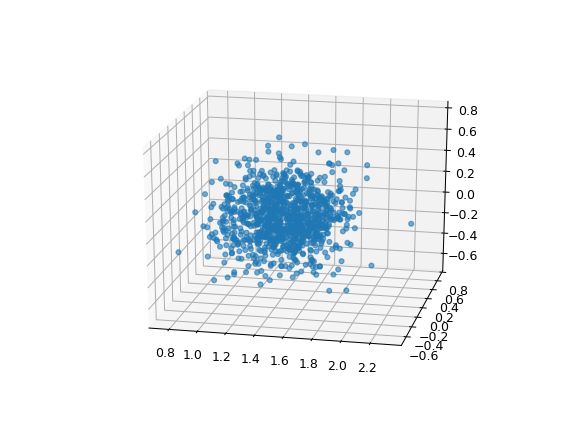

In [50]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(init_samples[:, 0], init_samples[:, 1], init_samples[:, 2],
           alpha=0.6, marker='o', s=15, color='C0')

## Initializations

In [51]:
dynamics = Dynamics(x_dim, distribution.get_energy_function(), 
                    T=10, eps=eps, net_factory=network, use_temperature=True)

In [52]:
x = tf.placeholder(tf.float32, shape=(None, x_dim))
z = tf.random_normal(tf.shape(x))

Lx, _, px, output = propose(x, dynamics, do_mh_step=True)
Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False)

loss = 0.

v1 = (tf.reduce_sum(tf.square(x - Lx), axis=1) * px) + 1e-4
v2 = (tf.reduce_sum(tf.square(z - Lz), axis=1) * pz) + 1e-4
scale = 0.1
loss += scale * (tf.reduce_mean(1.0 / v1) + tf.reduce_mean(1.0 / v2))
loss += (- tf.reduce_mean(v1, name='v1') 
         - tf.reduce_mean(v2, name='v2')) / scale
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [53]:
#help(tf.train.import_meta_graph)

#graph_meta_file = './log_mog_tf/run87/-20001.meta'
#imported_meta = tf.train.import_meta_graph('./log_mog_tf/run87/-20001.meta')


#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#summary = tf.summary.merge_all()
#init = tf.global_variables_initializer()
#sess = tf.Session(config=config)
#imported_meta.restore(sess, log_dir + '-200001')

In [54]:
global_step = tf.Variable(0., name='global_step', trainable=False)
learning_rate = tf.train.exponential_decay(init_learning_rate, global_step, 
                                           num_decay_steps, decay_rate,
                                           staircase=True)
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss, global_step=global_step)

In [55]:
#_tunneling_rate = tf.placeholder(tf.float32, shape=(train_traj_length, 
#                                                    n_training_samples, x_dim))
#_tunneling_rate = tf.placeholder(tf.float32, shape=(n_training_samples,))
#_mean, _var = tf.nn.moments(_tunneling_rate, axes=[0])
#_avg_tunneling_rate = _mean
#_avg_tunneling_rate_std = tf.sqrt(_var)

#_avg_tunneling_rate = 0.
#_avg_tunneling_rate_std = 0.

#tf.summary.scalar('avg_tunneling_rate_std', _avg_tunneling_rate_std_)
# L2HMC_samples[:_traj_length, idx], 
# Take the mean of you measure
#_avg_tunneling_rate = 0.
#tf.summary.scalar('avg_tunneling_rate', _avg_tunneling_rate_)

In [56]:
#init_tensorflow(log_dir)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
summary = tf.summary.merge_all()
init = tf.global_variables_initializer()
saver = tf.train.Saver()
sess = tf.Session(config=config)
#ckpt = tf.train.get_checkpoint_state(log_dir)
#if ckpt and ckpt.model_checkpoint_path:
#    saver.restore(sess, ckpt.model_checkpoint_path)
   
summary_writer = tf.summary.FileWriter(log_dir, sess.graph)
sess.run(init)

In [57]:
#training_samples = np.load(info_dir + 'training_samples.npy')
#temp_array = np.load(info_dir + 'temp_array.npy')
#params__ = np.load(info_dir + 'parameters.npy')
#means = np.load(info_dir + 'means.npy')
#covs = np.load(info_dir + 'covariances.npy')
#tunneling_info = np.load(info_dir + 'tunneling_info.npy')

In [58]:
log_parameters_file = info_dir + 'parameters.txt'
with open(log_parameters_file, 'w') as f:
    f.write((f"\ninitial_temp: {initial_temp}\n"
             f"\nannealing_steps: {annealing_steps}\n"
             f"\nannealing_factor: {annealing_rate}\n"
             f"\neps: {eps} (initial step size; trainable)\n"
             f"\nn_steps: {n_steps} (number of training steps)\n"
             f"\nn_samples: {n_samples}\n"
             f"\nn_training_samples: {n_training_samples}\n"
             f"\ntrain_traj_length: {train_traj_length}\n"
             f"\ninit_learning_rate: {init_learning_rate}\n"
             f"\nnum_decay_steps: {num_decay_steps}\n"
             f"\ndecay_rate: {decay_rate}\n"
             f"\nmeans:\n\n {str(means)}\n"
             f"\ncovs:\n\n {str(covs)}\n"))

866

## Training

In [18]:
annealing_steps

100

In [19]:
annealing_steps1 = 200

In [60]:
time1 = time.time()

for t in range(n_steps // 8):
    step_num = global_step.eval(session=sess) 
    feed_dict = {x: samples, 
                 dynamics.temperature: temp}
    
    _, loss_, samples, px_, lr_ = sess.run([
        train_op,
        loss,
        output[0],
        px,
        learning_rate,
    ], feed_dict=feed_dict)
    losses.append(loss_)

    if step_num % 50 == 0:
        if step_num  > 0:
            summary_str = sess.run(summary, feed_dict=feed_dict)
            summary_writer.add_summary(summary_str, step_num)
            summary_writer.flush()
            print(f'Step: {step_num} / {n_steps}, Loss: {loss_:.4e}, '
                  + f'Acceptance sample: {np.mean(px_):.2f}, LR: {lr_:.5f}, '
                  + f'temp: {temp:.5f}')
        
    if step_num % annealing_steps == 0:
        if temp <= 1.5:
            break
        temp *= annealing_rate
            
    if step_num % 500 == 0:
        #temp *= 0.98
        _samples = distribution.get_samples(n=n_training_samples)
        _training_samples = []
        for step in range(train_traj_length):
            _training_samples.append(np.copy(_samples)) 
            _feed_dict = {
                x: _samples, dynamics.temperature: 1.,
            } 
            _samples = sess.run(output[0], _feed_dict)
        
        _training_samples_arr = np.array(_training_samples)
        #_tunneling_events = []
        #_tunneling_rate_old = []
        _tunneling_rate = []
        #_tunneling_events_old = []
        _tunneling_events = []
        for i in range(_training_samples_arr.shape[1]):
            #events_old, rate_old = calc_tunneling_rate(_training_samples_arr[:, i, :], 
            #                                           min_distance)
            events, rate = find_tunneling_events(_training_samples_arr[:, i, :],
                                                 means)
            _tunneling_rate.append(rate)
            _tunneling_events.append(events)
            #_tunneling_rate[i] = rate
            # Take the mean of you measure
        # Create a new Summary object with your measure
        _avg_tunneling_rate = np.mean(_tunneling_rate)
        _avg_tunneling_rate_std = np.std(_tunneling_rate)
        #summary1 = tf.Summary()
        #summary1.value.add(tag="Avg tunneling rate", 
        #                   simple_value=_avg_tunneling_rate)
        #summary_writer.add_summary(summary1, global_step)

        
        #_tunneling_rate_ = tf.stack(_tunneling_rate)
        #_mean_, _var_ = tf.nn.moments(_tunneling_rate_, axes=[0])
        #_avg_tunneling_rate_ = _mean_
        #_avg_tunneling_rate_std_ = tf.sqrt(_var_)
        #with tf.name_scope('tunneling_rate'):
        #    variable_summaries(_tunneling_rate_)
            
        parameter_vals = [step_num,
                          n_training_samples, 
                          train_traj_length,
                          _avg_tunneling_rate,
                          _avg_tunneling_rate_std]
        
        all_tunneling_events[step_num] = _tunneling_events
        all_tunneling_rates[step_num] = _tunneling_rate
        tunneling_info.append(parameter_vals)
        #tunneling_events.append((step_num, _tunneling_events))
        training_samples.append(_training_samples)
        temp_arr.append(temp)
        print((f"\n\t Step: {step_num}, "
              f"Average tunneling rate: {_avg_tunneling_rate}, "
              f"Average tunneling rate std: {_avg_tunneling_rate_std}\n"))
              #\t Tunneling rate (old): {parameter_vals[-2]},

    if step_num % 2500 == 0:
        #step_num = global_step.eval(session=sess) 
        checkpoint_file = os.path.join(log_dir, 'model.ckpt')
        print(f'Saving checkpoint to: {checkpoint_file}')
        saver.save(sess, checkpoint_file, global_step=global_step)
                
#training_samples = np.array(training_samples)        
time2 = time.time()
dt1 = time2 - time1
print(f'Time for {n_steps//8} training steps was: {dt1} seconds.')

Step: 2500.0 / 20000, Loss: -2.7841e+02, Acceptance sample: 0.97, LR: 0.00092, temp: 6.03465

	 Step: 2500.0, Average tunneling rate: 1.5007503751875936e-05, Average tunneling rate std: 0.00012161326444365398

Saving checkpoint to: ./log_mog_tf/run141/model.ckpt


'./log_mog_tf/run141/model.ckpt-2501'

Step: 2550.0 / 20000, Loss: -2.6625e+02, Acceptance sample: 0.98, LR: 0.00092, temp: 5.91395
Step: 2600.0 / 20000, Loss: -2.6754e+02, Acceptance sample: 0.97, LR: 0.00092, temp: 5.91395
Step: 2650.0 / 20000, Loss: -2.5174e+02, Acceptance sample: 0.97, LR: 0.00092, temp: 5.79568
Step: 2700.0 / 20000, Loss: -2.7905e+02, Acceptance sample: 0.98, LR: 0.00092, temp: 5.79568
Step: 2750.0 / 20000, Loss: -2.4435e+02, Acceptance sample: 0.98, LR: 0.00092, temp: 5.67976
Step: 2800.0 / 20000, Loss: -2.6772e+02, Acceptance sample: 0.98, LR: 0.00092, temp: 5.67976
Step: 2850.0 / 20000, Loss: -2.8758e+02, Acceptance sample: 0.97, LR: 0.00092, temp: 5.56617
Step: 2900.0 / 20000, Loss: -2.6088e+02, Acceptance sample: 0.97, LR: 0.00092, temp: 5.56617
Step: 2950.0 / 20000, Loss: -2.6165e+02, Acceptance sample: 0.98, LR: 0.00092, temp: 5.45484
Step: 3000.0 / 20000, Loss: -2.5804e+02, Acceptance sample: 0.98, LR: 0.00088, temp: 5.45484

	 Step: 3000.0, Average tunneling rate: 1.0005002501250624e-05, Avera

In [21]:
#saver.save(sess, log_dir, global_step=global_step)

#ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
#ckpt = tf.train.get_checkpoint_state(log_dir)
#if ckpt and ckpt.model_checkpoint_path:
# saver.restore(sess, ckpt.model_checkpoint_path)

In [22]:
np.save(info_dir + 'training_samples', np.array(training_samples))
np.save(info_dir + 'temp_array', np.array(temp_arr))
#np.save(info_dir + 'annealing_schedule', np.array([m]))
np.save(info_dir + 'means', means)
np.save(info_dir + 'covariances', covs)
np.save(info_dir + 'tunneling_info', tunneling_info)

### After training, we generate $200$ chains for $2000$ steps for evaluation purposes.

In [23]:
final_samples = []
samples1 = distribution.get_samples(n=200)
trajectory_length = 2000

for t in range(trajectory_length):
    final_samples.append(np.copy(samples1))

    feed_dict = {
        x: samples1, dynamics.temperature: 1.0,
    }

    samples1 = sess.run(output[0], feed_dict)

np.save(info_dir + f'L2HMC_samples_{step_num}', np.array(final_samples))
L2HMC_samples = np.array(final_samples)

In [24]:
#min_distance = calc_min_dist(means, 0.02)
#tunneling_events0 = []
#_tunneling_rate_old_ = []
_tunneling_rate_ = []
#_parameter_vals_ = []
for i in range(L2HMC_samples.shape[1]):
    #_, rate_old = calc_tunneling_rate(L2HMC_samples[:, i, :], min_distance)
    _, _rate_ = find_tunneling_events(L2HMC_samples[:, i, :], means)
    #tunneling_events0.append(events)
    #_tunneling_rate_old_.append(rate_old)
    _tunneling_rate_.append(_rate_)

L2HMC_tunneling_rate.append([step_num, 
                             L2HMC_samples.shape[1], 
                             trajectory_length,  
                             #np.mean(_tunneling_rate_old_),
                             np.mean(_tunneling_rate_),
                             np.std(_tunneling_rate_)])
for row in np.array(L2HMC_tunneling_rate):
    #print(f"Old tunneling rate: {row[-2]:.5g},\t New tunneling rate: {row[-1]:.5g}")
    print(f"Average tunneling rate: {row[-2]:.5g}, std: {row[-1]:.5g}")
#tunneling_rate.append(parameter_vals)

#_tunneling_rate_arr_ = np.array(_tunneling_rate)

#np.save(info_dir + 'tunneling_rate_arr', tunneling_rate_arr)

#tunneling_rate_arr

Average tunneling rate: 0.063742, std: 0.0068948


## Intermediate L2HMC MCMC chains 

In [25]:
%matplotlib notebook
__samples = distribution.get_samples(1000)
_traj_length = 100
for idx in range(5):
    print(f"idx: {idx}")
    fig, ax = plot_trajectory_w_distribution(__samples, 
                                             L2HMC_samples[:_traj_length, idx], 
                                             x_dim=3)
    ax.view_init(elev=30, azim=-140)
    #ax.view_init(elev=20, azim=-75)
    plt.show()
    
fig, ax = plot_trajectory_w_distribution(__samples,
                                         L2HMC_samples[:_traj_length, 1],
                                         x_dim=3)
#str1 = f'tr (old): {np.array(L2HMC_tunneling_rate)[-1][-2]:.5g}, '
str1 = f'first {_traj_length} steps of trajectory\n'
str2 = f'tunneling rate: {np.array(L2HMC_tunneling_rate)[-1][-2]:.5g}'
ax.set_title(str1 + str2)
#ax.set_title(f'tunneling rate (old): {np.array(L2HMC_tunneling_rate)[-1][-1]:.5f}')
ax.view_init(elev=30, azim=-140)
fig.tight_layout()
out_file = figs_dir + f'MoG_trajectory_{_traj_length}t_{int(step_num)}train.png'
#out_file = './2D_MoG_trajectory_2000t_10000train_4.png'
print(f"Saving fig to: {out_file}")
fig.savefig(out_file, dpi=400, bbox_inches='tight')
#print(L2HMC_samples[:, idx].shape)

idx: 0


<IPython.core.display.Javascript object>

idx: 1


<IPython.core.display.Javascript object>

idx: 2


<IPython.core.display.Javascript object>

idx: 3


<IPython.core.display.Javascript object>

idx: 4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5,0.92,'first 100 steps of trajectory\ntunneling rate: 0.063742')

Saving fig to: ./log_mog_tf/run105/figures/MoG_trajectory_100t_2499train.png


In [26]:
tr_arr = np.array(tunneling_info)
print(tr_arr.shape)

step_nums_ = tr_arr[:, 0]
tr_ = tr_arr[:, -2]
#tr_new = tr_arr[:, -1]

(5, 5)


In [27]:
all_tunneling_rates_cp = {}
for key, val in all_tunneling_rates.items():
    new_key = int(key)
    all_tunneling_rates_cp[new_key] = val

all_tunneling_rates_arr = np.array(list(all_tunneling_rates_cp.values()))
#print(all_tunneling_rates_arr.shape)

avg_tr_vals = []
_avg_tr_vals = []
avg_tr_errs = []
for row in all_tunneling_rates_arr:
    avg_val = np.mean(row)
    avg_tr_vals.append(avg_val)
    data_rs = block_resampling(np.array(val), 100)
    avg_tr_rs = []
    for block in data_rs:
        avg_tr_rs.append(np.mean(block))
    _avg_tr_vals.append(np.mean(avg_tr_rs))
    error = jackknife_err(y_i = avg_tr_rs,
                          y_full = avg_val,
                          num_blocks = 20) / len(row)
    avg_tr_errs.append(error)

In [2]:
import numpy as np

In [8]:
x_dim=3
np.eye(x_dim)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [28]:
fig, ax = plt.subplots()
#ax.plot(step_nums_, tr_old, #yerr=tunneling_rates_old_err,
#            label='Old method', color='C0', marker='s', ls='-',
#            fillstyle='none')
        #fillstyle='none')
#ax.errorbar(step_nums_, tr_, yerr=tr_arr[:, -1], lw=1.5, capsize=2, capthick=2,
#            color='C0', marker='.', ls='-', fillstyle='none')
ax.errorbar(step_nums_, avg_tr_vals, yerr=avg_tr_errs, 
            capsize=1.5, capthick=1.5,
            color='C0', marker='.', ls='-', fillstyle='none')
            #fillstyle='none')
#ax.plot(step_nums76, tr_old76, label='Old method, run 2', 
#            color='C1', marker='o', fillstyle='none', ls='-')
#ax.plot(step_nums76, tr_new76, label='New method, run 2', 
#            color='C1', marker='o', ls='--')
        #al)
        #fillstyle='none')
ax.set_ylabel('Tunneling rate')#, fontsize=16)
ax.set_xlabel('Training step')#, fontsize=16)
#ax.legend(loc='best')#, markerscale=1.5), fontsize=12)
str1 = r"""$\mathcal{N}_1(\sqrt{2}\hat x; 0.05), $"""
str2 = r"""$\mathcal{N}_2(\sqrt{2}\hat y; 0.05),$ """
str3 = f"$T_0 =${initial_temp};  "
str22 = "\n"
str4 = r"""$T \rightarrow $ """ 
str5 = f"{annealing_rate}" 
str6 = r"""$\times T$ """
str7 = f"every {annealing_steps} steps"
#str5 = f"$ \times T$ every {annealing_steps} steps"
#str2 = (r"$T \rightarrow $" + f"{annealing_rate}" + " \times T$ "
#        f"every {annealing_steps} steps")
ax.set_title(str1 + str2 + str3 + str22 + str4 + str5 + str6 + str7)# + str2)
#ax.set_ylim((-0.05, 1.))
fig.tight_layout()
out_file = figs_dir + f'3D_tunneling_rate_vs_step_num_{int(step_num)}.png'
fig.savefig(out_file, dpi=400, bbox_inches='tight')

#np.save(info_dir + 'step_nums', step_nums_)
#np.save(info_dir + 'tr_old', tr_old)
#np.save(info_dir + 'tr_new', tr_new)

<IPython.core.display.Javascript object>

<ErrorbarContainer object of 3 artists>

Text(0,0.5,'Tunneling rate')

Text(0.5,0,'Training step')

Text(0.5,1,'$\\mathcal{N}_1(\\sqrt{2}\\hat x; 0.05), $$\\mathcal{N}_2(\\sqrt{2}\\hat y; 0.05),$ $T_0 =$10;  \n$T \\rightarrow $ 0.98$\\times T$ every 100 steps')

## Create animation

In [ ]:
def update_lines(num, dataLines, lines):
    for line, data in zip(lines, dataLines):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
    return lines

In [ ]:
# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, 25, fargs=(data, lines),
                                   interval=50, blit=False)

In [ ]:
lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1])[0] for dat in data]

In [ ]:
print(str1)

In [ ]:
fig, ax = plot_trajectory_w_distribution(init_samples, 
                                         L2HMC_samples[:, 8], 
                                         x_dim=3)
ax.view_init(elev=38, azim=38)
plt.show()
fig.tight_layout()
out_file = './3D_MoG_trajectory_2000t_20000train_0.png'
fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
fig, ax = plot_trajectory_w_distribution(init_samples, 
                                         L2HMC_samples[:200, 0], 
                                         x_dim=3)
for idx in range(50):
    #print(f"idx: {idx}")
    ax.plot(L2HMC_samples[:200, idx, 0], 
            L2HMC_samples[:200, idx, 1], 
            L2HMC_samples[:200, idx, 2], 
            color='C1', marker='o', ls='-', alpha=0.6, markersize=1)#, fillstyle='none')
    ax.view_init(elev=38, azim=38)
    plt.show()
#fig.tight_layout()
#out_file = './3D_MoG_trajectory_200t_20000train_50samples_0.png'
#fig.savefig(out_file, dpi=400, bbox_inches='tight')

## Try Generic HMC

We compute the HMC chains with **auto-correlation spectrums** as well.

In [ ]:
HMC_samples_0 = get_hmc_samples(2, 0.1, distribution.get_energy_function(), sess, steps=2000, samples=samples)

In [ ]:
HMC_samples_1 = get_hmc_samples(2, 0.2, distribution.get_energy_function(), sess, steps=2000, samples=samples)
HMC_samples_2 = get_hmc_samples(2, 0.3, distribution.get_energy_function(), sess, steps=2000, samples=samples)
HMC_samples_3 = get_hmc_samples(2, 0.5, distribution.get_energy_function(), sess, steps=2000, samples=samples)

In [ ]:
HMC0 = acl_spectrum(HMC_samples_0, scale=scale)

In [ ]:
scale = np.sqrt(np.trace(covs))
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

We can plot auto-correlation.

In [ ]:
xaxis = 10 * np.arange(300)
fig, ax = plt.subplots()
ax.plot(xaxis, L2HMC[:300]/max(L2HMC[:300]), label='L2HMC')
ax.plot(xaxis, HMC0[:300]/max(HMC0[:300]), label='HMC $\epsilon=0.1$')
ax.plot(xaxis, HMC1[:300]/max(HMC1[:300]), label='HMC $\epsilon=0.2$')
ax.plot(xaxis, HMC2[:300]/max(HMC2[:300]), label='HMC $\epsilon=0.3$')
ax.plot(xaxis, HMC3[:300]/max(HMC3[:300]), label='HMC $\epsilon=0.5$')
ax.set_ylabel('Auto-correlation')
ax.set_xlabel('Gradient Computations')
#ax.set_xlim((0, 200))
ax.legend()
fig.tight_layout()
fig.savefig('./auto_correlation_vs_grad_comps_MoG_mixed.png', 
            dpi=400, bbox_inches='tight')
plt.show()

We now compute the **Effective Sample Size** (ESS).

In [ ]:
print('ESS L2HMC: %.2e -- ESS HMC: %.2e -- Ratio: %d' % (ESS(L2HMC), ESS(HMC2), ESS(L2HMC) / ESS(HMC2)))

We can visualize a single chain of both HMC and L2HMC for $500$ time steps.


In [ ]:
fig, ax = plt.subplots()
ax.plot(HMC_samples_0[:100, 1, 0], HMC_samples_0[:100, 1, 1], 
         color='C1', marker='o', alpha=0.8, ls='-')
ax.set_title("Single chain of HMC $(\epsilon = 0.1)$ for 1000 time steps")
fig.tight_layout()
fig.savefig('./MoG_HMC_chain_e01_100t_1.png', dpi=400, bbox_inches='tight')
plt.show()

## OLD

In [ ]:
(after 5000 training steps)

In [ ]:
_training_samples_ = np.copy(np.array(training_samples))
print(_training_samples_.shape)

In [ ]:
fig, ax = plot_trajectory_w_distribution(init_samples,
                                         _training_samples_[-2, :100, 0],
                                         x_dim=3)

_temp = temp_arr[-2]
ax.view_init(elev=38, azim=38)
ax.set_title(f'T = {_temp}')
fig.tight_layout()
out_file = f'./3D_MoG_trajectory_temp{_temp:.1f}_1.png'
fig.savefig(out_file, dpi=400, bbox_inches='tight')
                                     #_training_samples_[-2, :100, 0, 0],
                                         #_training_samples_[-2, :100, 0, 0],
                                         #color='C1', marker='o', ls='-', 
                                         #alpha=0.6, markersize=1, 
                                         #fillstyle='none')

In [ ]:
for idx in range(len(_training_samples_)):
    _temp = temp_arr[idx]
    fig, ax = plot_trajectory_w_distribution(init_samples, 
                                             _training_samples_[idx, :, 0], 
                                             x_dim=3)
    for i in range(_training_samples_.shape[2]):
        ax.plot(_training_samples_[idx, :, i, 0], 
                _training_samples_[idx, :, i, 1], 
                _training_samples_[idx, :, i, 2], 
                color='C1', marker='o', ls='-', 
                alpha=0.6, markersize=1)#, fillstyle='none')
    ax.view_init(elev=38, azim=38)
    ax.set_title(f'T = {_temp}')
    fig.tight_layout()
    #out_dir = './figures/training_trajectories/'
    #out_file = out_dir + f'3D_MoG_training_trajectory_temp{_temp:.1f}_0.png'
    #if not os.path.isfile(out_file):
    #    print(f"Saving figure to file: {out_file}")
    #    fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
#%matplotlib inline
#for i in range(10, 20):
#    print(f'i: {i}')
#fig, ax = plt.subplots()
#ax.scatter(init_samples[:,0], init_samples[:,1], color='C0')
#ax.plot(L2HMC_samples[:, -i, 0], L2HMC_samples[:, -i, 1], 
#        marker='o', color='C1', alpha=0.8)
#plt.show()
#init_samples = distribution.get_samples(n=n_samples)
for i in range(30, 40):
    print(f'i: {i}')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.scatter(init_samples[:, :1], init_samples[:, 2], s=15, color='C0')
    ax.scatter(init_samples[:, 0], init_samples[:, 1], 
               init_samples[:, 2], s=15, color='C0') 
    ax.plot(L2HMC_samples[:, i, 0], 
            L2HMC_samples[:, i, 1], 
            L2HMC_samples[:, i, 2], color='C1')#, ls='-', lw='10')
    plt.show()
    
#ax.scatter(init_samples[:, :1], init_samples[:,2], s=15)
#plt.show()

#fig, ax = plt.subplots()
#ax.plot(L2HMC_samples[:200, 2, 0], L2HMC_samples[:200, 2, 1], 
#        color='C1', marker='o', alpha=0.6, ls='-')
#ax.scatter(init_samples[:, 0], init_samples[:, 1], color='C0')
#fig.tight_layout()
#out_file = './3D_MoG_trajectory_2000t_5000train_2.png'
#out_file = './2D_MoG_trajectory_2000t_10000train_4.png'
#fig.savefig(out_file, dpi=400, bbox_inches='tight')
#plt.show()